In [52]:
from __future__ import division, unicode_literals

import pandas as pd
import numpy as np
import math

from sklearn.metrics import roc_auc_score
from pandas.tools.plotting import scatter_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as pl

# Чтение данных

In [53]:
train = pd.read_csv('train.csv', encoding='utf-8', 
                    dialect='excel', lineterminator='\n')

assert(train.columns[-1] == 'retweet_count')

train_f = train[['user.statuses_count', 'user.followers_count', 
                'user.friends_count', 'user.listed_count', 'user.favourites_count']]

# Пре-процессинг данных

Размеры данный

In [69]:
print train_f.shape

(67211, 5)


In [55]:
train_f.head()

,user.statuses_count,user.followers_count,user.friends_count,user.listed_count,user.favourites_count
0,1606,9164,205,27,758
1,3004,7484,708,330,44
2,3988,2050,491,70,422
3,9018,919,309,38,79
4,32527,85356,912,1232,137


Характеристики данных

In [56]:
train_f.describe()

,user.statuses_count,user.followers_count,user.friends_count,user.listed_count,user.favourites_count
count,6.721100e+04,6.721100e+04,6.721100e+04,67211.000000,67211.000000
mean,9.214209e+04,2.493563e+05,6.381893e+03,1829.584012,3488.091994
std,1.990518e+05,1.101774e+06,3.638143e+04,8257.238243,12399.361134
min,6.000000e+00,3.500000e+01,0.000000e+00,0.000000,0.000000
25%,9.716500e+03,8.762000e+03,4.030000e+02,138.000000,111.000000
50%,2.799800e+04,4.064900e+04,9.290000e+02,471.000000,722.000000
75%,7.583100e+04,1.462430e+05,2.659000e+03,1332.000000,2481.000000
max,1.775275e+06,6.622713e+07,3.131983e+06,584387.000000,623798.000000


Построим корреляционную матрицу для оценивания наличия линейной зависимости между признаками. Можно заметить, что признауи не скореллированы, только 'user.listed_count' и 'user.followers_count' имеют коэффициетн = 0.846. Это следует учитывать при построении линейных классификаторов.

In [57]:
train_f.corr()

,user.statuses_count,user.followers_count,user.friends_count,user.listed_count,user.favourites_count
user.statuses_count,1.000000,0.052894,0.127003,0.054768,0.024958
user.followers_count,0.052894,1.000000,0.136822,0.845898,0.022280
user.friends_count,0.127003,0.136822,1.000000,0.099393,0.179443
user.listed_count,0.054768,0.845898,0.099393,1.000000,0.020612
user.favourites_count,0.024958,0.022280,0.179443,0.020612,1.000000


Визуализация данных.
Диапазон значений параметров довольно сильно отличается. Пэтому их необходимо преобразовать. Добавим +1 к каждому параметру и прологорифмируем эти значения.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113a99bd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1113965d0>]], dtype=object)

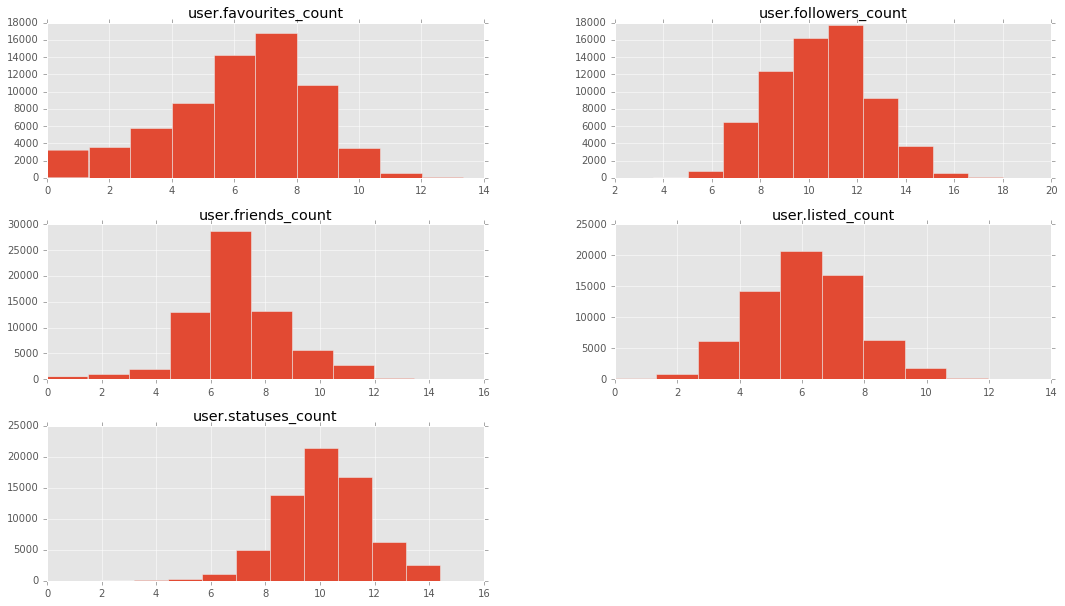

In [117]:
plt.style.use('ggplot')
# init data
# pd.DataFrame.hist(train_f, figsize = [18,10])
train_log = train_f.applymap(lambda x : x + 1).applymap(math.log)
# data ufter log operation
pd.DataFrame.hist(train_log, figsize = [18,10])

# train_log.corr()

# Пример вычисления признаков

In [59]:
def df2features(df):
    return np.array([
        df['user.id'],
        df['user.followers_count'],
    ]).transpose()

train_x = df2features(train)
train_y = train['retweet_count'] > 20

# Построение модели

Пример вычисления площади под ROC-кривой на обучающей выборке.

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, svm

from sklearn.metrics import roc_curve, auc

In [61]:
model_dtc = DecisionTreeClassifier()
model_lr = LogisticRegression(penalty='l1', tol=0.01)
model_rfc = RandomForestClassifier(n_estimators = 10)
model_knc = KNeighborsClassifier(n_neighbors = 10)

Кросс-валидация

In [62]:
train_x_ROC, test_x_ROC, train_y_ROC, test_y_ROC = cross_validation.train_test_split(train_x, train_y, test_size=0.2)

In [63]:
kfold = 5 #количество подвыборок для валидации
acc_val = {}
scores = cross_validation.cross_val_score(model_dtc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['DecisionTreeClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_lr, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['LogisticRegression'] = scores.mean()
scores = cross_validation.cross_val_score(model_rfc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['RandomForestClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_knc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['KNeighborsClassifier'] = scores.mean()


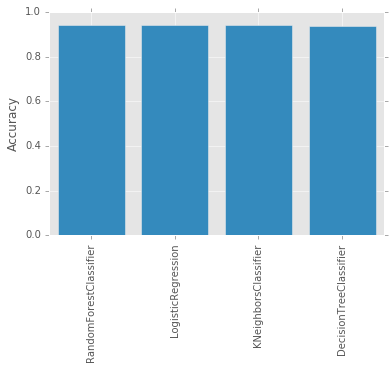

In [64]:
plt.bar(range(len(acc_val)), acc_val.values(), align='center')
plt.xticks(range(len(acc_val)), acc_val.keys(), rotation='vertical')
pl.ylabel('Accuracy')
plt.show()

Визуализация ROC-кривой

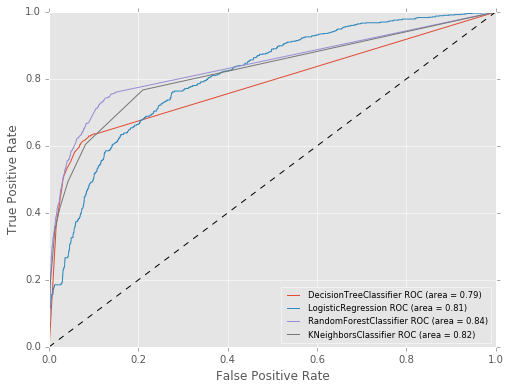

In [65]:
pl.clf()
plt.figure(figsize=(8,6))
#DecisionTreeClassifier
probas = model_dtc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('DecisionTreeClassifier',roc_auc))
#LogisticRegression
probas = model_lr.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
#RandomForestClassifier
probas = model_rfc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForestClassifier',roc_auc))
#KNeighborsClassifier
probas = model_knc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))

pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()